In [1]:
using StatsBase
using Distributions
using Random
using Serialization
using Plots

# Input parameters

const BURN_IN_GEN_N = 1000
const TOTAL_GEN_N = 2000

# Max coordinates of the population bounding space
const X_MAX_BURN_IN = 5
const X_MAX = 500

const X_START = X_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = X_MAX

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.9
const S_SELECT_COEF = 0.005

0.005

In [2]:
function float32_test(procid)
    Random.seed!(procid)

    x_range = 1:Int(X_START)
    init_coords = sample(x_range,DEMES_FULL_AT_START;replace=false)

    world = Array{Array{Array{Float32}}}(undef,X_DIM)

    for coord in init_coords
        if !isassigned(world,coord)
            world[coord] = []
        end
        for i in 1:K_CAPACITY
            push!(world[coord],ones(LOCI_N*2))
        end
    end

    @inbounds function multi_fitn_in_person(person)
        return prod(person)
    end

    @inbounds function max_fitn(persons_at_pos)
        return maximum(multi_fitn_in_person.(persons_at_pos))
    end

    @inbounds function mean_fitn(persons_at_pos)
        return mean(multi_fitn_in_person.(persons_at_pos))
    end

    @inbounds function mutate(person)
        get_mutation_random = rand(Poisson(MUT_RATE))
        @fastmath @inbounds for _ in 1:get_mutation_random
            pos_alter = sample(1:LOCI_N)
            if rand() < MUT_DELETER_RATE
                person[pos_alter] *= 1 - S_SELECT_COEF
            else
                person[pos_alter] *= 1 + S_SELECT_COEF
            end
        end
    end

    @inbounds function recombine(person)
        for i in 1:LOCI_N
            lr = rand(1:2)
            person[i] = lr==1 ? person[i] : person[i+LOCI_N]
        end
    end

    @inbounds function mate_cond(mom_fit,dad_fit,max_fitness)
        return (mom_fit > rand()*max_fitness) & (dad_fit > rand()*max_fitness)
    end

    @inbounds function mate(person1,person2)
        new_loci = vcat(person1[1:LOCI_N],person2[1:LOCI_N])
        return new_loci
    end

    @inbounds @inbounds function build_next_gen(wld,x_max_migrate)
        # Function 1
        next_gen_pops = zeros(Int16,X_DIM)
        next_gen_posits = []
        fill!(next_gen_pops,-1)
        for x in 1:X_DIM
            if isassigned(world,x) && length(world[x])>0
                n_ppl_at_deme = length(world[x])
                expected_offspring = n_ppl_at_deme * (R_PROLIF_RATE/(1 + (n_ppl_at_deme*(R_PROLIF_RATE-1))/K_CAPACITY))
                next_gen_pops[x] =  rand(Poisson(expected_offspring))
                if next_gen_pops[x]>0
                    push!(next_gen_posits,x)
                end
            end
        end
        

        # Function 2
        #wld_next = Array{Person}(undef,sum(next_gen_pops))
        wld_next = Array{Array{Array{Float32}}}(undef,X_DIM)
        
        all_birth_count = 0

        # Function 3
        mean_fitn_wld = Array{Float32}(undef,X_DIM)
        fill!(mean_fitn_wld,-1)
        pops_wld = zeros(Int32,X_DIM)

        for deme in next_gen_posits
            curr_persons_at_pos = wld[deme]
            mean_fitn_wld[deme] = mean_fitn(curr_persons_at_pos)
            max_fitness =  max_fitn(curr_persons_at_pos)

            next_generation_size = next_gen_pops[deme]
            
            if next_generation_size > 0
                birth_count = 0
                while birth_count < next_generation_size
                    mom = curr_persons_at_pos[rand(1:end)]
                    dad = curr_persons_at_pos[rand(1:end)]
                    mom_fit = multi_fitn_in_person(mom)
                    dad_fit = multi_fitn_in_person(dad)




                    #print(mate_cond(relative_extract_xx_ind,relative_extract_xy_ind,max_fitness))
                    if mate_cond(mom_fit,dad_fit,max_fitness)
                        #println(mom)
                        gamete_mom = copy(mom) # technically a person, but we'll only use the first half of loci
                        gamete_dad = copy(dad) # technically a person, but we'll only use the first half of loci
                        recombine(gamete_mom)
                        recombine(gamete_dad)
                        mutate(gamete_mom)
                        mutate(gamete_dad)
                        mate_result = mate(gamete_mom,gamete_dad)

                        wv = [M_MIG_RATE/2,1-M_MIG_RATE,M_MIG_RATE/2]
                        move_x = sample(-1:1,Weights(wv))
                        if deme[1]+move_x > x_max_migrate || deme[1]+move_x < 1
                            #move_x = 0
                            move_x = -move_x
                        end
                        if !isassigned(wld_next,deme[1]+move_x)
                            wld_next[deme[1]+move_x] = []
                        end
                        push!(wld_next[deme[1]+move_x],mate_result)

                        birth_count += 1
                        all_birth_count += 1
                    end
                end
                pops_wld[deme] = birth_count
            end
        end
        return wld_next,mean_fitn_wld,pops_wld
    end

    meanf_world = Array{Float32}(undef,X_DIM,0)
    pops_world = Array{Float32}(undef,X_DIM,0)

    @inbounds for _ in 1:BURN_IN_GEN_N
        world,meanf,pops = build_next_gen(world,X_MAX_BURN_IN)
        meanf_world = cat(meanf_world,meanf, dims=2)
        pops_world = cat(pops_world,pops, dims=2)
    end

    @inbounds for _ in (BURN_IN_GEN_N+1):TOTAL_GEN_N
        world,meanf,pops = build_next_gen(world,X_MAX)
        meanf_world = cat(meanf_world,meanf, dims=2)
        pops_world = cat(pops_world,pops, dims=2)
    end

    defined_world = []
    for i in 1:X_DIM
        if isassigned(world,i)
            push!(defined_world, world[i])
        end
    end
    serialize("../output/1d_floattest/float32_$procid-meanf.dat",meanf_world)
    open("../output/1d_floattest/results.txt", "w") do file
        write(file,string("Population (Float32): ",sum(length.(defined_world))))
    end
end

float32_test (generic function with 1 method)

In [3]:
function float64_test(procid)
    Random.seed!(procid)

    x_range = 1:Int(X_START)
    init_coords = sample(x_range,DEMES_FULL_AT_START;replace=false)

    world = Array{Array{Array{Float64}}}(undef,X_DIM)

    for coord in init_coords
        if !isassigned(world,coord)
            world[coord] = []
        end
        for i in 1:K_CAPACITY
            push!(world[coord],ones(LOCI_N*2))
        end
    end

    @inbounds function multi_fitn_in_person(person)
        return prod(person)
    end

    @inbounds function max_fitn(persons_at_pos)
        return maximum(multi_fitn_in_person.(persons_at_pos))
    end

    @inbounds function mean_fitn(persons_at_pos)
        return mean(multi_fitn_in_person.(persons_at_pos))
    end

    @inbounds function mutate(person)
        get_mutation_random = rand(Poisson(MUT_RATE))
        @fastmath @inbounds for _ in 1:get_mutation_random
            pos_alter = sample(1:LOCI_N)
            if rand() < MUT_DELETER_RATE
                person[pos_alter] *= 1 - S_SELECT_COEF
            else
                person[pos_alter] *= 1 + S_SELECT_COEF
            end
        end
    end

    @inbounds function recombine(person)
        for i in 1:LOCI_N
            lr = rand(1:2)
            person[i] = lr==1 ? person[i] : person[i+LOCI_N]
        end
    end

    @inbounds function mate_cond(mom_fit,dad_fit,max_fitness)
        return (mom_fit > rand()*max_fitness) & (dad_fit > rand()*max_fitness)
    end

    @inbounds function mate(person1,person2)
        new_loci = vcat(person1[1:LOCI_N],person2[1:LOCI_N])
        return new_loci
    end

    @inbounds @inbounds function build_next_gen(wld,x_max_migrate)
        # Function 1
        next_gen_pops = zeros(Int16,X_DIM)
        next_gen_posits = []
        fill!(next_gen_pops,-1)
        for x in 1:X_DIM
            if isassigned(world,x) && length(world[x])>0
                n_ppl_at_deme = length(world[x])
                expected_offspring = n_ppl_at_deme * (R_PROLIF_RATE/(1 + (n_ppl_at_deme*(R_PROLIF_RATE-1))/K_CAPACITY))
                next_gen_pops[x] =  rand(Poisson(expected_offspring))
                if next_gen_pops[x]>0
                    push!(next_gen_posits,x)
                end
            end
        end
        

        # Function 2
        #wld_next = Array{Person}(undef,sum(next_gen_pops))
        wld_next = Array{Array{Array{Float64}}}(undef,X_DIM)
        
        all_birth_count = 0

        # Function 3
        mean_fitn_wld = Array{Float64}(undef,X_DIM)
        fill!(mean_fitn_wld,-1)
        pops_wld = zeros(Int64,X_DIM)

        for deme in next_gen_posits
            curr_persons_at_pos = wld[deme]
            mean_fitn_wld[deme] = mean_fitn(curr_persons_at_pos)
            max_fitness =  max_fitn(curr_persons_at_pos)

            next_generation_size = next_gen_pops[deme]
            
            if next_generation_size > 0
                birth_count = 0
                while birth_count < next_generation_size
                    mom = curr_persons_at_pos[rand(1:end)]
                    dad = curr_persons_at_pos[rand(1:end)]
                    mom_fit = multi_fitn_in_person(mom)
                    dad_fit = multi_fitn_in_person(dad)




                    #print(mate_cond(relative_extract_xx_ind,relative_extract_xy_ind,max_fitness))
                    if mate_cond(mom_fit,dad_fit,max_fitness)
                        #println(mom)
                        gamete_mom = copy(mom) # technically a person, but we'll only use the first half of loci
                        gamete_dad = copy(dad) # technically a person, but we'll only use the first half of loci
                        recombine(gamete_mom)
                        recombine(gamete_dad)
                        mutate(gamete_mom)
                        mutate(gamete_dad)
                        mate_result = mate(gamete_mom,gamete_dad)

                        wv = [M_MIG_RATE/2,1-M_MIG_RATE,M_MIG_RATE/2]
                        move_x = sample(-1:1,Weights(wv))
                        if deme[1]+move_x > x_max_migrate || deme[1]+move_x < 1
                            #move_x = 0
                            move_x = -move_x
                        end
                        if !isassigned(wld_next,deme[1]+move_x)
                            wld_next[deme[1]+move_x] = []
                        end
                        push!(wld_next[deme[1]+move_x],mate_result)

                        birth_count += 1
                        all_birth_count += 1
                    end
                end
                pops_wld[deme] = birth_count
            end
        end
        return wld_next,mean_fitn_wld,pops_wld
    end

    meanf_world = Array{Float64}(undef,X_DIM,0)
    pops_world = Array{Float64}(undef,X_DIM,0)

    @inbounds for _ in 1:BURN_IN_GEN_N
        world,meanf,pops = build_next_gen(world,X_MAX_BURN_IN)
        meanf_world = cat(meanf_world,meanf, dims=2)
        pops_world = cat(pops_world,pops, dims=2)
    end

    @inbounds for _ in (BURN_IN_GEN_N+1):TOTAL_GEN_N
        world,meanf,pops = build_next_gen(world,X_MAX)
        meanf_world = cat(meanf_world,meanf, dims=2)
        pops_world = cat(pops_world,pops, dims=2)
    end

    defined_world = []
    for i in 1:X_DIM
        if isassigned(world,i)
            push!(defined_world, world[i])
        end
    end
    serialize("../output/1d_floattest/float64_$procid-meanf.dat",meanf_world)
    open("../output/1d_floattest/results.txt", "w") do file
        println("Population (Float64): ",sum(length.(defined_world)))
    end
end

float64_test (generic function with 1 method)

In [17]:
for i in 11:15
    float32_test(i)
    float64_test(i)
end

Population (Float32): 24825


Population (Float64): 25393


Population (Float32): 25423


Population (Float64): 

25070
Population (Float32): 25519


Population (Float64): 25315


Population (Float32): 25261


Population (Float64): 25265


Population (Float32): 24472


Population (Float64): 25892


In [2]:
function get_normalised_matrix_max(meanfit_array)
    normal_array = copy(meanfit_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanfit_array[:,BURN_IN_GEN_N+j])
        normal_array[:,BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

function get_normalised_matrix_onset_mean(meanfit_array)
    normal_array = copy(meanfit_array)
    
    sum = 0
    count = 0
    for u in meanfit_array[:,BURN_IN_GEN_N+1]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_max = sum/count

    normal_array[:,BURN_IN_GEN_N+1:end] /= gen_max
    return normal_array
end

function find_front32(meanfit_array,gen_n=TOTAL_GEN_N)
    front_array = Array{Float32}(undef,0)
    for j in 1:gen_n
        frontier = X_MAX
        while frontier != 1 && meanfit_array[frontier,j] < 0
            frontier -= 1
        end
        sum_total = meanfit_array[frontier,j]
        front_array = cat(front_array,sum_total, dims=1)
    end
    return front_array
end

function find_front64(meanfit_array,gen_n=TOTAL_GEN_N)
    front_array = Array{Float64}(undef,0)
    for j in 1:gen_n
        frontier = X_MAX
        while frontier != 1 && meanfit_array[frontier,j] < 0
            frontier -= 1
        end
        sum_total = meanfit_array[frontier,j]
        front_array = cat(front_array,sum_total, dims=1)
    end
    return front_array
end

find_front64 (generic function with 2 methods)

In [3]:
const N_IN_BATCH = 15

meanfitness32_set = [deserialize("../output/1d_floattest/float32_$i-meanf.dat") for i in 1:N_IN_BATCH]
meanfitness64_set = [deserialize("../output/1d_floattest/float64_$i-meanf.dat") for i in 1:N_IN_BATCH]

15-element Vector{Matrix{Float64}}:
 [1.0 0.99965 … 1.4897030298239147 1.4929454850262878; 1.0 0.9995299145299146 … 1.4800681596137992 1.4857159447933006; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9995796728971963 … 1.3527187157378686 1.3509491703410121; 1.0 0.9997826086956522 … 1.3533825213894655 1.362838928359145; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9997087378640777 … 1.3607908472147472 1.3586488856209844; 1.0 0.9997413793103448 … 1.3564445287360927 1.3528974731953545; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9995410714285715 … 1.2547538739527992 1.2519997151805768; 1.0 0.9995263157894737 … 1.2522915000319397 1.2516648960412335; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9996703296703296 … 1.366209366039656 1.3652644126710465; 1.0 0.9990724226804125 … 1.3821858055579075 1.3860845971261906; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9995915816326532 … 1.3222177239903803 1.3221877973430154; 1.0 0.99984

In [4]:
mf_norm32_set = [get_normalised_matrix_onset_mean(k) for k in meanfitness32_set]
mf_front_norm32_set = [find_front32(k) for k in mf_norm32_set]
mf_front_norm32_matrix = reduce(hcat,mf_front_norm32_set)'
mf_front_norm32_average = [mean(mf_front_norm32_matrix[:,i]) for i in 1:TOTAL_GEN_N]

mf_norm64_set = [get_normalised_matrix_onset_mean(k) for k in meanfitness64_set]
mf_front_norm64_set = [find_front64(k) for k in mf_norm64_set]
mf_front_norm64_matrix = reduce(hcat,mf_front_norm64_set)'
mf_front_norm64_average = [mean(mf_front_norm64_matrix[:,i]) for i in 1:TOTAL_GEN_N]

2000-element Vector{Float64}:
 1.0
 0.9996163224104249
 0.9992263623225964
 0.9988378409760625
 0.9985387448662115
 0.9982090843648496
 0.9977706168643727
 0.9973082385006024
 0.9967402886963589
 0.9964419094987375
 ⋮
 0.6912040879634023
 0.6895448117001215
 0.6901048147935448
 0.6897599266305616
 0.6895255074763366
 0.6875625351707818
 0.6881301708409424
 0.6880524683789766
 0.6881424228068873

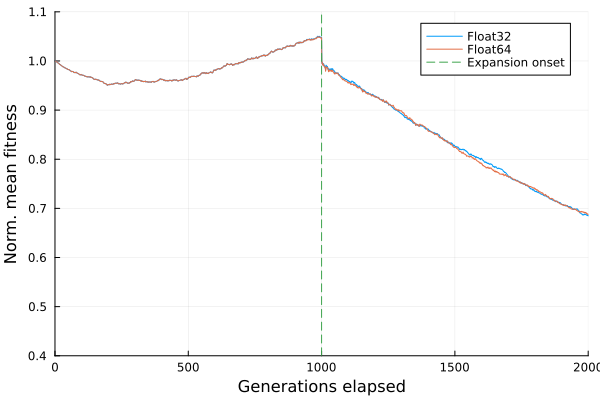

In [12]:
plot(mf_front_norm32_average,label = "Float32",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",yrange=(0.4,1.1))
plot!(mf_front_norm64_average,label = "Float64",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",yrange=(0.4,1.1))
vline!([BURN_IN_GEN_N],label="Expansion onset",style=:dash)

In [6]:
mf_front32_set = [find_front32(meanfitness32_set[i]) for i in 1:N_IN_BATCH]
mf_front32_matrix = reduce(hcat,mf_front32_set)'
mf_front32_average = [mean(mf_front32_matrix[:,i]) for i in 1:TOTAL_GEN_N]
mf_front64_set = [find_front64(meanfitness64_set[i]) for i in 1:N_IN_BATCH]
mf_front64_matrix = reduce(hcat,mf_front64_set)'
mf_front64_average = [mean(mf_front64_matrix[:,i]) for i in 1:TOTAL_GEN_N]

2000-element Vector{Float64}:
 1.0
 0.9996163224104249
 0.9992263623225964
 0.9988378409760625
 0.9985387448662115
 0.9982090843648496
 0.9977706168643727
 0.9973082385006024
 0.9967402886963589
 0.9964419094987375
 ⋮
 0.7273521628904914
 0.7256260631738151
 0.7262156226294995
 0.7258444531877181
 0.7255937168762318
 0.7234820370711642
 0.7241345853107571
 0.7240361267439223
 0.7241310443570991

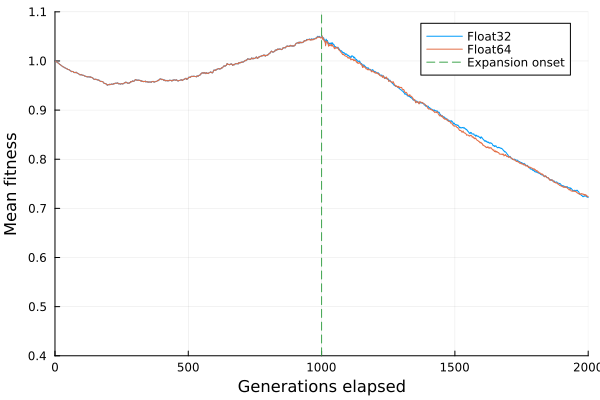

In [11]:
plot(mf_front32_average,label = "Float32",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Mean fitness",yrange=(0.4,1.1))
plot!(mf_front64_average,label = "Float64",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Mean fitness",yrange=(0.4,1.1))
vline!([BURN_IN_GEN_N],label="Expansion onset",style=:dash)

In [10]:
(mf_front64_average[end]-mf_front32_average[end])/mf_front32_average[end]

0.0027716919709554833

In [13]:
#= using StatsBase
using Distributions

const BURN_IN_GEN_N = 800
const TOTAL_GEN_N = 1100
const X_MAX_BURN_IN = 5
const X_MAX = 500
const X_START = X_MAX_BURN_IN
const X_DIM = X_MAX

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 1
const S_SELECT_COEF = 0.005

global mut_pos = 1
global migr_pos = 1

x_range = 1:Int(X_START)
init_coords = sample(x_range,DEMES_FULL_AT_START;replace=false)

world = Array{Array{Array{Float32}}}(undef,X_DIM)

for coord in init_coords
    if !isassigned(world,coord)
        world[coord] = []
    end
    for i in 1:K_CAPACITY
        push!(world[coord],ones(LOCI_N*2))
    end
end

@inbounds function multi_fitn_in_person(person)
    return prod(person)
end

@inbounds function max_fitn(persons_at_pos)
    return maximum(multi_fitn_in_person.(persons_at_pos))
end

@inbounds function mean_fitn(persons_at_pos)
    return mean(multi_fitn_in_person.(persons_at_pos))
end

@inbounds function mutate(person)
    get_mutation_random = rand(Poisson(MUT_RATE))
    @fastmath @inbounds for _ in 1:get_mutation_random
        pos_alter = mut_pos
        global mut_pos = (mut_pos+1)%LOCI_N+1
        if rand() < MUT_DELETER_RATE
            person[pos_alter] *= 1 - S_SELECT_COEF
        else
            person[pos_alter] *= 1 + S_SELECT_COEF
        end
    end
end

@inbounds function recombine(person)
    for i in 1:LOCI_N
        lr = 1
        person[i] = lr==1 ? person[i] : person[i+LOCI_N]
    end
end

@inbounds function mate_cond(mom_fit,dad_fit,max_fitness)
    return (mom_fit > rand()*max_fitness) & (dad_fit > rand()*max_fitness)
end

@inbounds function mate(person1,person2)
    new_loci = vcat(person1[1:LOCI_N],person2[1:LOCI_N])
    return new_loci
end

@inbounds @inbounds function build_next_gen(wld,x_max_migrate)
    # Function 1
    next_gen_pops = zeros(Int16,X_DIM)
    next_gen_posits = []
    fill!(next_gen_pops,-1)
    for x in 1:X_DIM
        if isassigned(world,x) && length(world[x])>0
            n_ppl_at_deme = length(world[x])
            expected_offspring = n_ppl_at_deme * (R_PROLIF_RATE/(1 + (n_ppl_at_deme*(R_PROLIF_RATE-1))/K_CAPACITY))
            next_gen_pops[x] =  trunc(Int, expected_offspring)
            if next_gen_pops[x]>0
                push!(next_gen_posits,x)
            end
        end
    end
    

    # Function 2
    #wld_next = Array{Person}(undef,sum(next_gen_pops))
    wld_next = Array{Array{Array{Float32}}}(undef,X_DIM)
    
    all_birth_count = 0

    # Function 3
    mean_fitn_wld = Array{Float32}(undef,X_DIM)
    fill!(mean_fitn_wld,-1)
    pops_wld = zeros(Int32,X_DIM)

    for deme in next_gen_posits
        curr_persons_at_pos = wld[deme]
        mean_fitn_wld[deme] = mean_fitn(curr_persons_at_pos)
        max_fitness =  max_fitn(curr_persons_at_pos)

        next_generation_size = next_gen_pops[deme]
        pers1_pos = 1
        pers2_pos = 2
        if next_generation_size > 0
            birth_count = 0
            while birth_count < next_generation_size
                mom = curr_persons_at_pos[pers1_pos]
                dad = curr_persons_at_pos[pers2_pos]
                pers1_pos = (pers1_pos+1)%length(curr_persons_at_pos)+1
                pers2_pos = (pers2_pos+1)%length(curr_persons_at_pos)+1
                mom_fit = multi_fitn_in_person(mom)
                dad_fit = multi_fitn_in_person(dad)




                #print(mate_cond(relative_extract_xx_ind,relative_extract_xy_ind,max_fitness))
                if true
                    #println(mom)
                    gamete_mom = copy(mom) # technically a person, but we'll only use the first half of loci
                    gamete_dad = copy(dad) # technically a person, but we'll only use the first half of loci
                    recombine(gamete_mom)
                    recombine(gamete_dad)
                    mutate(gamete_mom)
                    mutate(gamete_dad)
                    mate_result = mate(gamete_mom,gamete_dad)


                    move_x = migr_pos-1
                    global migr_pos = (migr_pos+1)%3
                    if deme[1]+move_x > x_max_migrate || deme[1]+move_x < 1
                        #move_x = 0
                        move_x = -move_x
                    end
                    if !isassigned(wld_next,deme[1]+move_x)
                        wld_next[deme[1]+move_x] = []
                    end
                    push!(wld_next[deme[1]+move_x],mate_result)

                    birth_count += 1
                    all_birth_count += 1
                end
            end
            pops_wld[deme] = birth_count
        end
    end
    return wld_next,mean_fitn_wld,pops_wld
end

meanf_world = Array{Float32}(undef,X_DIM,0)
pops_world = Array{Float32}(undef,X_DIM,0)

@inbounds for _ in 1:BURN_IN_GEN_N
    global world,meanf,pops = build_next_gen(world,X_MAX_BURN_IN)
    global meanf_world = cat(meanf_world,meanf, dims=2)
    global pops_world = cat(pops_world,pops, dims=2)
end

@inbounds for _ in (BURN_IN_GEN_N+1):TOTAL_GEN_N
    global world,meanf,pops = build_next_gen(world,X_MAX)
    global meanf_world = cat(meanf_world,meanf, dims=2)
    global pops_world = cat(pops_world,pops, dims=2)
end

defined_world = []
for i in 1:X_DIM
    if isassigned(world,i)
        push!(defined_world, world[i])
    end
end
println(sum(length.(defined_world))) =#